<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_40_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

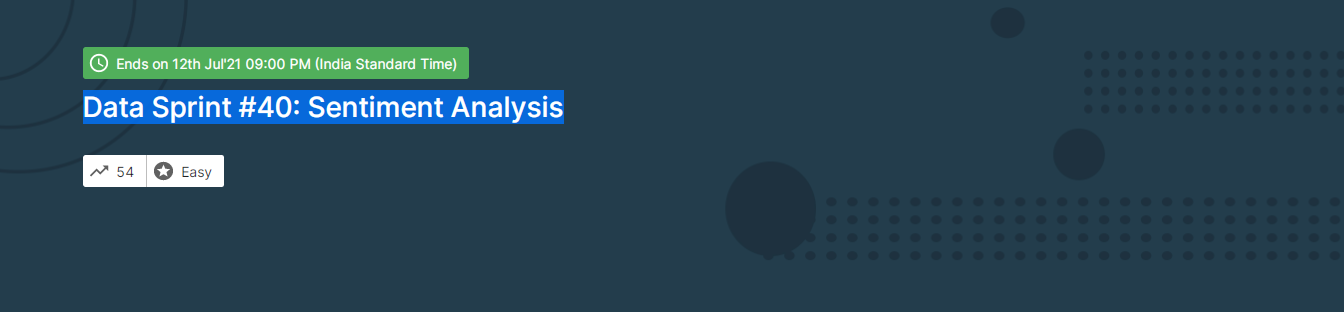

## Problem Statement
 

Sentiment analysis studies the subjective information in an expression, that is, the opinions, appraisals, emotions, or attitudes towards a topic, person or entity. Expressions can be classified as positive, negative, or neutral. For example: “I really like the new design of your website!” → Positive.

 

You are provided the review datasets taken from different websites like IMDB, Yelp and Amazon. Build a machine learning model to predict the label of the review either positive or negative.

## Data Description

There are two features - 
* ‘review’ - the sentence and 
* ‘sentiment’ - the label for the review. 

**1 means positive review**

**0 means negative review.**

**Integrating Fairseq’s RoBERTa model via Hugging Face’s Transformers and fast.ai libraries** to solve the problem statement

In [1]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.4MB/s 
     |████████████████████████████████| 3.3MB 37.4MB/s 
     |████████████████████████████████| 901kB 33.7MB/s 


In [2]:
from google.colab import files
files.upload()

Saving Sample_Submission (2).csv to Sample_Submission (2).csv
Saving Train_Data.csv to Train_Data.csv
Saving Test_Data.csv to Test_Data.csv


{'Sample_Submission (2).csv': b'prediction\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\

## Data Science Packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## fastai

In [4]:
from fastai.text import *
from fastai.metrics import *

## Transformer Pipeline _Tokenizer

* RoBERTa uses different default special tokens from BERT. For example, instead of **[CLS]** and **[SEP]** for starting and ending tokens, **<s>** and **</s>** are used respectively.

In [8]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

In [5]:
from transformers import RobertaTokenizer
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

## Create a Fastai wrapper around RobertaTokenizer

In [6]:
class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]


## Initialize our Fastai tokenizer: 

(Note: we have to wrap our Fastai wrapper within the Tokenizer class for Fastai compatibility)

In [7]:
fastai_tokenizer = Tokenizer(tok_func = FastAiRobertaTokenizer(roberta_tok, max_seq_len=256), pre_rules=[], post_rules=[])

## Create fastai vocabulary for roberta -Load Roberta’s vocabulary.

In [15]:
path = Path()
roberta_tok.save_vocabulary(path) 
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

##  Setting up pre-processors

In [16]:
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), RobertaNumericalizeProcessor(vocab=vocab)]

## Read Training and Test Data

In [9]:
train = pd.read_csv("/content/Train_Data.csv")
test = pd.read_csv("/content/Test_Data.csv")

In [10]:
train.head()

,review,sentiment
0,think robert ryans best film portrayed someone...,1
1,juano hernandez exceptional actor played suppo...,1
2,shocked sign indicate cash,0
3,sat another ten minute finally gave left,0
4,igo charger tip really great,1


In [33]:
label_mapper = {0:'NEGATIVE',1:'POSITIVE'}

In [34]:
train['sentiment'] = train['sentiment'].map(label_mapper)

In [11]:
text = train.review.values.tolist()

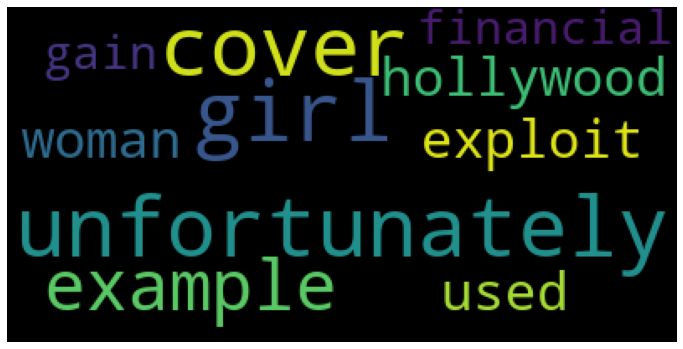

In [43]:
from wordcloud import WordCloud
wordclouds = WordCloud().generate(text[100])
plt.figure(figsize=(12,8))
plt.imshow(wordclouds)
plt.axis('off')
plt.show()

In [12]:
test.head()

,review
0,great service food
1,pairing iphone could happier far
2,plot hole pair fishnet stocking direction edit...
3,surely doesnt know make coherent action movie ...
4,still quite interesting entertaining follow


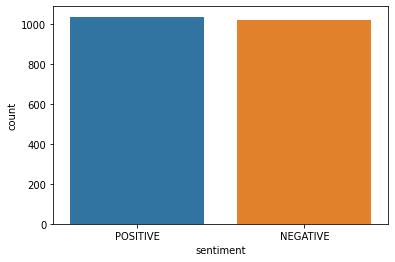

In [35]:
sns.countplot(x='sentiment',data=train)

In [14]:
train.shape

(2060, 2)

## Setting up the DataBunch

In [17]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [44]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

## loading the tokenizer and vocab processors

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
feat_cols = "review"
label_cols = "sentiment"

In [46]:
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = RobertaTextList.from_df(train, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

In [39]:
data.show_batch()

text,target
<s> fact Ġhard Ġremember Ġpart Ġray Ġchar les Ġacted Ġplayed Ġman Ġray Ġchar les Ġlegendary Ġray Ġchar les Ġlife Ġprovided Ġexcellent Ġbi ographical Ġmaterial Ġfilm Ġgo Ġwell Ġbeyond Ġanother Ġmovie Ġmusician Ġhitch cock Ġgreat Ġdirector Ġironically Ġmostly Ġfind Ġfilm Ġtotal Ġwaste Ġtime Ġwatch Ġsecondly Ġhitch cock Ġpretty Ġmuch Ġperfected Ġthriller Ġchase Ġmovie Ġpand ering Ġaudience Ġsabotage Ġfilm Ġhence Ġwhole Ġstory Ġlack Ġcertain Ġenergy Ġplot Ġsimply Ġrum ble Ġlike Ġmachine Ġdesperately,NEGATIVE
<s> ach ille Ġph ilipp a Ġbeautifully Ġsing Ġdu et Ġg iov anni Ġperfectly Ġdescribes Ġsituation Ġmovie Ġappreciate Ġsubtle Ġlayer Ġexcellent Ġfilm </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>,POSITIVE
<s> received Ġwhite Ġcolored Ġbattery Ġgo Ġdead Ġcouple Ġhour st he Ġoriginal Ġused Ġlast Ġweek Ġstill Ġlast Ġlonger Ġthere pl acement </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>,NEGATIVE
<s> best Ġexample Ġdumb Ġwriting Ġestablished Ġturn Ġz omb iest ud ents Ġback Ġhuman Ġremoving Ġnecklace Ġcontaining Ġpiece Ġmeteor ite </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>,NEGATIVE


## Building the Model

In [84]:
import torch
import torch.nn as nn
from transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask,return_dict=False) # 
        logits = self.classifier(pooled_output)        
        return logits

**Note**

 There is a class probably named Bert_Arch that inherits the nn.Module and this class has a overriden method named forward. Inside forward method just add the parameter **'return_dict=False'** to the self.bert() method call. in order to avoid the below error :-

 **TypeError: linear(): argument 'input' (position 1) must be Tensor, not str**

In [85]:
roberta_model = CustomRobertaModel(num_labels=2)

learn = Learner(data, roberta_model, metrics=[accuracy])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [86]:
roberta_model 

CustomRobertaModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [87]:
config

{'bs': 4,
 'end_tok': '</s>',
 'epochs': 1,
 'hidden_dropout_prob': 0.05,
 'hidden_size': 768,
 'max_lr': 1e-05,
 'max_seq_len': 256,
 'num_labels': 2,
 'roberta_model_name': 'roberta-base',
 'seed': 2019,
 'start_tok': '<s>',
 'testing': False,
 'use_fp16': False}

In [88]:
learn.model.roberta.train()


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [89]:
learn.fit_one_cycle(3, max_lr=1e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.402385,0.416808,0.837379,00:30
1,0.255522,0.294917,0.890777,00:30
2,0.193952,0.286495,0.895631,00:30


## Saving/Loading the model weights

In [91]:
learn.save('base_model')

In [92]:
learn.load('base_model')

Learner(data=RobertaDataBunch;

Train: LabelList (1648 items)
x: RobertaTextList
<s> ju ano Ġher n and ez Ġexceptional Ġactor Ġplayed Ġsupporting Ġrole Ġmany Ġfilm Ġera Ġproud Ġblack Ġman Ġaccused Ġmurdering Ġwhite Ġman Ġsouth </s>,<s> sh ocked Ġsign Ġindicate Ġcash </s>,<s> sat Ġanother Ġten Ġminute Ġfinally Ġgave Ġleft </s>,<s> igo Ġcharger Ġtip Ġreally Ġgreat </s>,<s> wind Ġlion Ġsee Ġwonderful Ġrendering Ġameric a Ġimperial Ġage </s>
y: CategoryList
POSITIVE,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE
Path: .;

Valid: LabelList (412 items)
x: RobertaTextList
<s> hor rible Ġattitude Ġtowards Ġcustomer Ġtalk Ġone Ġcustomer Ġdont Ġenjoy Ġfood </s>,<s> go Ġplace Ġgy ro </s>,<s> le ast Ġthink Ġrefill Ġwater Ġstruggle Ġwave Ġminute </s>,<s> inst ruction Ġdidnt Ġexplain Ġmicrophone Ġjack Ġcould Ġused </s>,<s> love Ġphone </s>
y: CategoryList
NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,POSITIVE
Path: .;

Test: LabelList (686 items)
x: RobertaTextList
<s> great Ġservice Ġfood </s>,<s> pair ing Ġ iph one Ġc

In [ ]:
def save_model(learner, file_name):
    st = learner.model.state_dict()
    torch.save(st, file_name) # will save model in current dir # backend is pickle 

def load_model(learner, file_name):
    st = torch.load(file_name)
    learner.model.load_state_dict(st)

# monkey patching Learner methods to save and load model file
Learner.save_model = save_model
Learner.load_model = load_model

## Fine Tune Learner

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


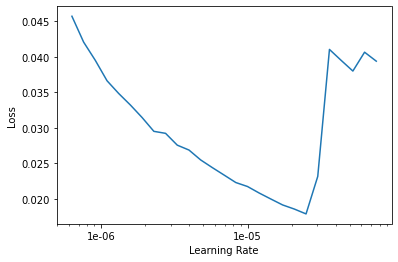

In [78]:
learn.unfreeze()

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(5, max_lr=1e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.253355,0.507849,0.837379,00:30
1,0.321345,0.376927,0.844660,00:29
2,0.198286,0.421750,0.851942,00:29
3,0.192173,0.447749,0.851942,00:29
4,0.169698,0.470481,0.859223,00:29


## Add Test Dataset to data

In [74]:
test_datalist = TextList.from_df(test, cols='review', vocab=data.classes)

data.add_test(test_datalist)
data.show_batch()

text,target
<s> fact Ġhard Ġremember Ġpart Ġray Ġchar les Ġacted Ġplayed Ġman Ġray Ġchar les Ġlegendary Ġray Ġchar les Ġlife Ġprovided Ġexcellent Ġbi ographical Ġmaterial Ġfilm Ġgo Ġwell Ġbeyond Ġanother Ġmovie Ġmusician Ġhitch cock Ġgreat Ġdirector Ġironically Ġmostly Ġfind Ġfilm Ġtotal Ġwaste Ġtime Ġwatch Ġsecondly Ġhitch cock Ġpretty Ġmuch Ġperfected Ġthriller Ġchase Ġmovie Ġpand ering Ġaudience Ġsabotage Ġfilm Ġhence Ġwhole Ġstory Ġlack Ġcertain Ġenergy Ġplot Ġsimply Ġrum ble Ġlike Ġmachine Ġdesperately,NEGATIVE
<s> acting even Ġprofessional Ġdr ago Ġdeb bie Ġro ch on was Ġterrible Ġdirecting Ġworse Ġperhaps Ġcontribut ory Ġformer Ġdialog Ġchim pl ike Ġcamera Ġwork Ġbarely Ġtoler able </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>,NEGATIVE
<s> du et Ġastronaut Ġdoctor Ġbeginning Ġmovie Ġperfect Ġexchange Ġone Ġconsiders Ġmovie Ġmade Ġwell Ġcold Ġwar Ġastronaut Ġbiggest Ġfear Ġcrashed Ġus sr </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>,POSITIVE
<s> description Ġsaid Ġy um Ġy um Ġsauce Ġanother Ġsaid Ġe el Ġsauce Ġyet Ġanother Ġsaid Ġspicy Ġmay owell Ġnone Ġroll Ġsauce </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>,NEGATIVE


In [75]:
data

RobertaDataBunch;

Train: LabelList (1648 items)
x: RobertaTextList
<s> ju ano Ġher n and ez Ġexceptional Ġactor Ġplayed Ġsupporting Ġrole Ġmany Ġfilm Ġera Ġproud Ġblack Ġman Ġaccused Ġmurdering Ġwhite Ġman Ġsouth </s>,<s> sh ocked Ġsign Ġindicate Ġcash </s>,<s> sat Ġanother Ġten Ġminute Ġfinally Ġgave Ġleft </s>,<s> igo Ġcharger Ġtip Ġreally Ġgreat </s>,<s> wind Ġlion Ġsee Ġwonderful Ġrendering Ġameric a Ġimperial Ġage </s>
y: CategoryList
POSITIVE,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE
Path: .;

Valid: LabelList (412 items)
x: RobertaTextList
<s> hor rible Ġattitude Ġtowards Ġcustomer Ġtalk Ġone Ġcustomer Ġdont Ġenjoy Ġfood </s>,<s> go Ġplace Ġgy ro </s>,<s> le ast Ġthink Ġrefill Ġwater Ġstruggle Ġwave Ġminute </s>,<s> inst ruction Ġdidnt Ġexplain Ġmicrophone Ġjack Ġcould Ġused </s>,<s> love Ġphone </s>
y: CategoryList
NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,POSITIVE
Path: .;

Test: LabelList (686 items)
x: RobertaTextList
<s> great Ġservice Ġfood </s>,<s> pair ing Ġ iph one Ġcould Ġhappier

In [73]:
data.c,data.classes

(2, ['NEGATIVE', 'POSITIVE'])

## Make Predictions

In [93]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [94]:
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [64]:
pred_values

array([0, 1, 0, 0, ..., 1, 1, 1, 1])

## Calculate Accuracy on validation dataset

In [95]:
# accuracy on valid
(pred_values == data.valid_ds.y.items).mean()

0.8956310679611651

## Confusion Matrix

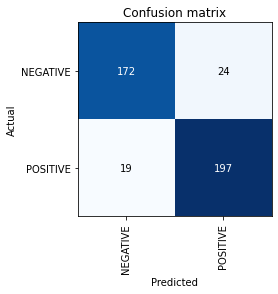

In [96]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Make Predictions on Test Data

In [97]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [101]:
test['prediction'] = test_preds[1].tolist()

In [102]:
test.head()

,review,prediction
0,great service food,1
1,pairing iphone could happier far,1
2,plot hole pair fishnet stocking direction edit...,1
3,surely doesnt know make coherent action movie ...,0
4,still quite interesting entertaining follow,1


## Download Predictions to a csv file

In [103]:
test[['prediction']].to_csv('Roberta.csv',index=False)

* **Submission successful! Your score is 83.09037900874635.**